<a href="https://colab.research.google.com/github/MannP7610/Speedbreaker-Potholes-detection-using-Efficientnet/blob/main/SbnPh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install torch torchvision torchaudio
!pip install opencv-python
!pip install matplotlib pandas

In [ ]:
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import os
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt  # Make sure to import pyplot
from torchvision.models.detection.anchor_utils import AnchorGenerator

In [ ]:
!unzip -q /content/drive/MyDrive/Speedbreaker.zip -d /content/Speedbreaker
!unzip -q /content/drive/MyDrive/Potholes.zip -d /content/Potholes

replace /content/Speedbreaker/README.dataset.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
replace /content/Potholes/README.dataset.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
speedbreaker_dir = '/content/Speedbreaker/train'
pothole_dir = '/content/Potholes/train'

In [ ]:
class ObjectDetectionDataset(Dataset):
    def __init__(self, root, annotations_file, transforms=None):
        self.root = root
        self.transforms = transforms
        self.annotations = pd.read_csv(annotations_file)
        self.imgs = list(self.annotations['filename'].unique())

    def __getitem__(self, idx):
        # Load image
        img_name = self.imgs[idx]
        img_path = os.path.join(self.root, img_name)
        img = Image.open(img_path).convert("RGB")

        # Load annotations
        records = self.annotations[self.annotations['filename'] == img_name]
        boxes = []
        labels = []

        for i, row in records.iterrows():
            xmin = row['xmin']
            ymin = row['ymin']
            xmax = row['xmax']
            ymax = row['ymax']
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(1 if row['class'] == "speed-breaker" else 2)  # Class '1' for speedbreaker, '2' for pothole

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {"boxes": boxes, "labels": labels}

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
def get_transform(train):
    transforms = []
    transforms.append(torchvision.transforms.ToTensor())
    if train:
        transforms.append(torchvision.transforms.RandomHorizontalFlip(0.5))  # Horizontal flip
        transforms.append(torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2))  # Color jitter
    return torchvision.transforms.Compose(transforms)


In [ ]:
def get_model_instance_segmentation(num_classes):
    # Load Faster R-CNN model pre-trained on COCO
    backbone = torchvision.models.resnet50(pretrained=True)
    backbone = torch.nn.Sequential(*list(backbone.children())[:-2])
    backbone.out_channels = 2048

    anchor_generator = AnchorGenerator(
        sizes=((32, 64, 128, 256, 512),),
        aspect_ratios=((0.5, 1.0, 2.0),) * len((32, 64, 128, 256, 512))
    )

    roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'], output_size=7, sampling_ratio=2)

    model = FasterRCNN(backbone,
                       num_classes=num_classes,
                       rpn_anchor_generator=anchor_generator,
                       box_roi_pool=roi_pooler)

    return model

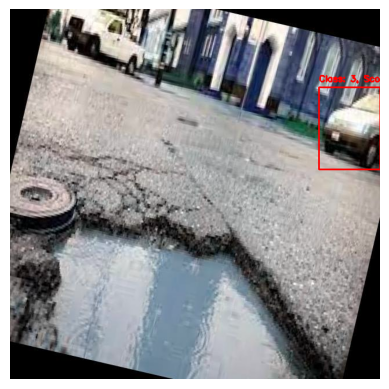

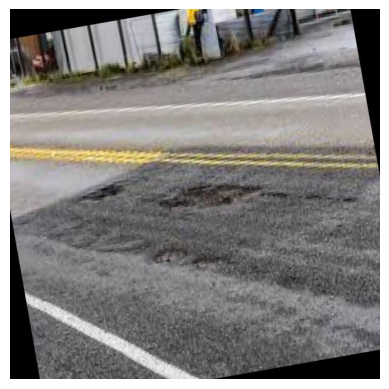

In [ ]:
import cv2
import matplotlib.pyplot as plt
from torchvision.ops import nms
import numpy as np #Added import for numpy

def visualize_predictions(images, outputs, threshold=0.5, iou_threshold=0.5):
    for i, image in enumerate(images):
        # Convert image tensor to numpy array and scale to 0-255
        image_np = image.mul(255).permute(1, 2, 0).byte().cpu().numpy()
        image_np = image_np.astype(np.uint8)  # Ensure the data type is uint8

        # Apply NMS to filter boxes
        keep = nms(outputs[i]['boxes'], outputs[i]['scores'], iou_threshold)
        boxes = outputs[i]['boxes'][keep]
        scores = outputs[i]['scores'][keep]
        labels = outputs[i]['labels'][keep]

        # Filter predictions based on confidence threshold
        for box, score, label in zip(boxes, scores, labels):
            if score > threshold:  # Only show boxes above confidence threshold
                box = box.cpu().numpy().astype(int)
                # Convert the image to BGR (OpenCV default) before drawing
                image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR) # Added line to fix the error
                cv2.rectangle(image_np, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 2)
                cv2.putText(image_np, f'Class: {label.item()}, Score: {score.item():.2f}',
                            (box[0], box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

        plt.imshow(image_np)
        plt.axis('off')  # Hide axes
        plt.show()

# Example usage in the evaluation loop
with torch.no_grad():
    model.eval()  # Set the model to eval mode
    for images, targets in test_loader:
        images = list(image.to(device) for image in images)
        outputs = model(images)
        visualize_predictions(images, outputs, threshold=0.5, iou_threshold=0.5)  # Call the visualization function
        break  # Show results for the first batch only

In [ ]:

# Function to evaluate the model and compute Average IoU
def evaluate(model, loader):
    model.eval()
    with torch.no_grad():
        iou_list = []
        for images, targets in loader:
            images = list(image.to(device) for image in images)
            outputs = model(images)

            for target, output in zip(targets, outputs):
                if len(output['boxes']) == 0:
                    print("No predictions made.")
                    continue  # Skip if no predictions

                if len(target['boxes']) == 0:
                    print("No ground truth boxes.")
                    continue

                iou = torchvision.ops.box_iou(target["boxes"], output["boxes"]).mean().item()

                if not np.isnan(iou):
                    iou_list.append(iou)

        if len(iou_list) > 0:
            avg_iou = np.mean(iou_list)
        else:
            avg_iou = 0.0

        print(f"Average IOU: {avg_iou}")

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
speedbreaker_annotations = os.path.join('/content/Speedbreaker/train', '_annotations.csv')
pothole_annotations = os.path.join('/content/Potholes/train', '_annotations.csv')

In [ ]:
train_dataset = ObjectDetectionDataset(speedbreaker_dir, speedbreaker_annotations, get_transform(train=True))
test_dataset = ObjectDetectionDataset(pothole_dir, pothole_annotations, get_transform(train=False))

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

In [ ]:
!pip install torchvision # install torchvision using pip
import torchvision # import the torchvision library

num_classes = 3  # 1 (background) + 2 (speedbreaker, pothole)
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True) # use the torchvision library to access the FasterRCNN object
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)

In [ ]:
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

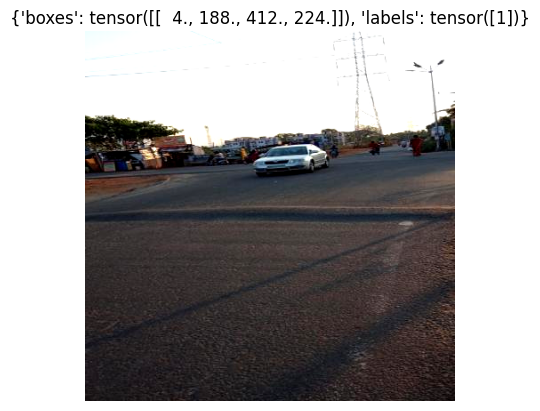

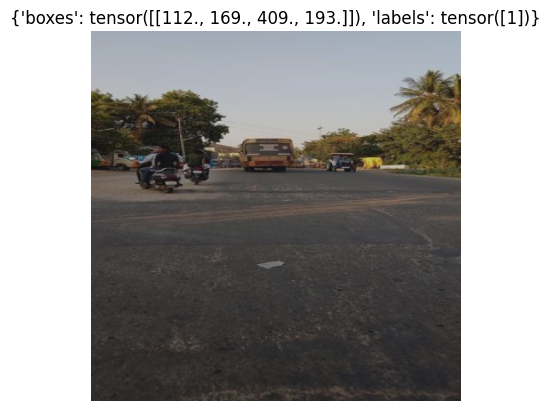

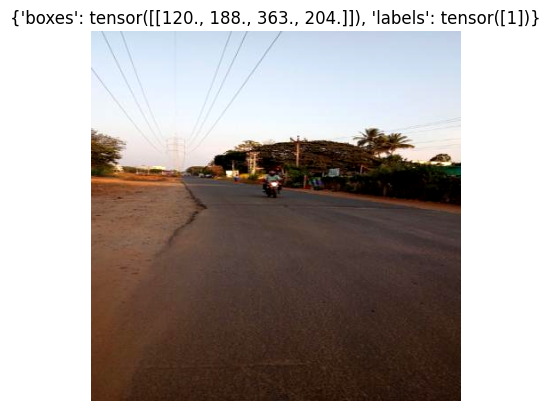

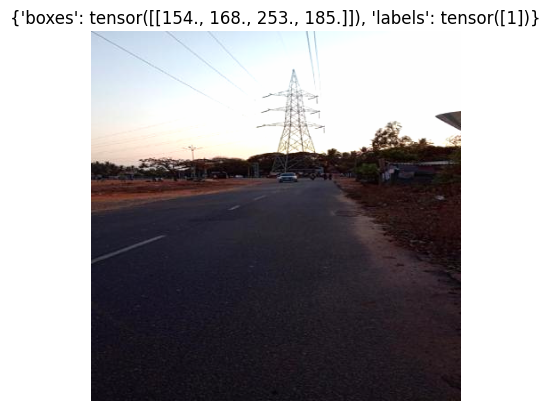

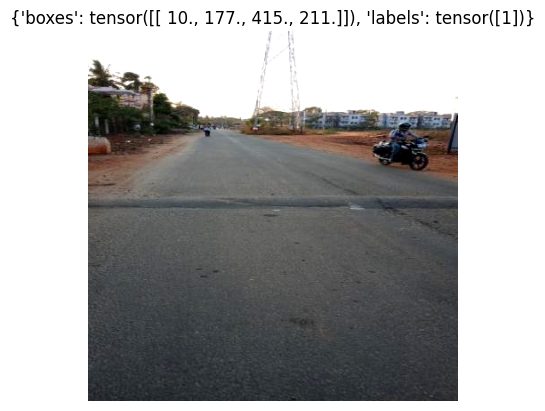

In [ ]:
# Visualize sample images and their corresponding annotations
import random
sample_indices = random.sample(range(len(train_dataset)), 5)
for idx in sample_indices:
    img, target = train_dataset[idx]
    plt.imshow(img.permute(1, 2, 0).cpu().numpy())
    plt.title(str(target))
    plt.axis('off')
    plt.show()


Epoch 0, Iteration 0: Loss = 1.0604335069656372
Epoch 0, Iteration 10: Loss = 0.32015249133110046
Epoch 0, Iteration 20: Loss = 0.39467641711235046
Epoch 0, Iteration 30: Loss = 0.40358680486679077
Epoch 0 completed. Average Loss: 0.4726


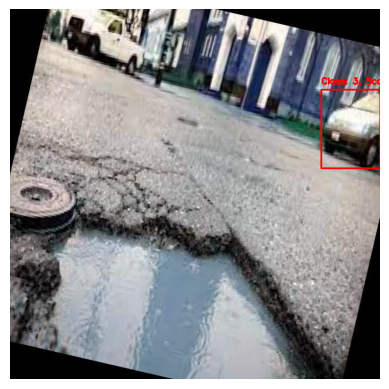

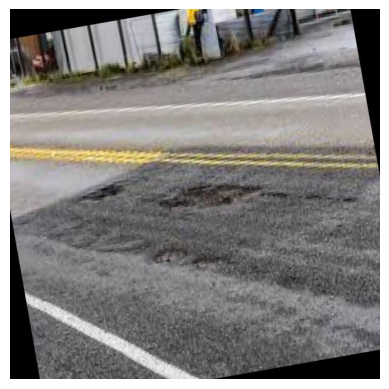

Epoch 1, Iteration 0: Loss = 0.30714327096939087
Epoch 1, Iteration 10: Loss = 0.19638949632644653
Epoch 1, Iteration 20: Loss = 0.19909793138504028
Epoch 1, Iteration 30: Loss = 0.26008331775665283
Epoch 1 completed. Average Loss: 0.2830
Epoch 2, Iteration 0: Loss = 0.23380032181739807
Epoch 2, Iteration 10: Loss = 0.4121192693710327
Epoch 2, Iteration 20: Loss = 0.22809641063213348
Epoch 2, Iteration 30: Loss = 0.2724264860153198
Epoch 2 completed. Average Loss: 0.2477
Epoch 3, Iteration 0: Loss = 0.1398022174835205
Epoch 3, Iteration 10: Loss = 0.18635641038417816
Epoch 3, Iteration 20: Loss = 0.19860994815826416
Epoch 3, Iteration 30: Loss = 0.15101569890975952
Epoch 3 completed. Average Loss: 0.2021
Epoch 4, Iteration 0: Loss = 0.156109020113945
Epoch 4, Iteration 10: Loss = 0.1824558675289154
Epoch 4, Iteration 20: Loss = 0.28862816095352173
Epoch 4, Iteration 30: Loss = 0.28106459975242615
Epoch 4 completed. Average Loss: 0.1920
Epoch 5, Iteration 0: Loss = 0.14426030218601227
E

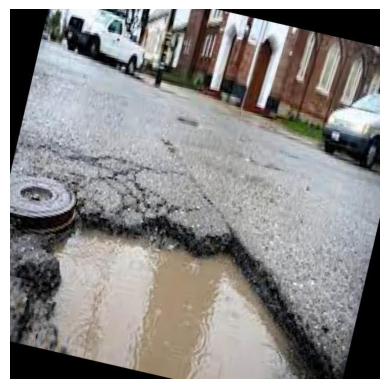

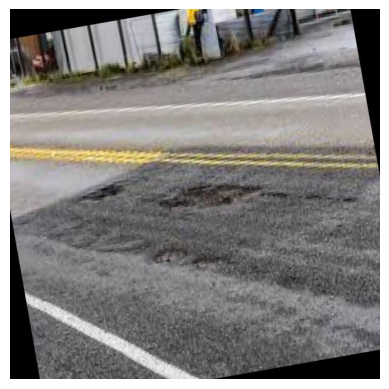

Epoch 11, Iteration 0: Loss = 0.19267255067825317
Epoch 11, Iteration 10: Loss = 0.12385851889848709
Epoch 11, Iteration 20: Loss = 0.09137760102748871
Epoch 11, Iteration 30: Loss = 0.05989377573132515
Epoch 11 completed. Average Loss: 0.1322
Epoch 12, Iteration 0: Loss = 0.0935741662979126
Epoch 12, Iteration 10: Loss = 0.0765654444694519
Epoch 12, Iteration 20: Loss = 0.1057935506105423
Epoch 12, Iteration 30: Loss = 0.12007094919681549
Epoch 12 completed. Average Loss: 0.1193
Epoch 13, Iteration 0: Loss = 0.08430135250091553
Epoch 13, Iteration 10: Loss = 0.1928057223558426
Epoch 13, Iteration 20: Loss = 0.09151776134967804
Epoch 13, Iteration 30: Loss = 0.10495588183403015
Epoch 13 completed. Average Loss: 0.1287
Epoch 14, Iteration 0: Loss = 0.12096410989761353
Epoch 14, Iteration 10: Loss = 0.08667672425508499
Epoch 14, Iteration 20: Loss = 0.10046752542257309
Epoch 14, Iteration 30: Loss = 0.12105858325958252
Epoch 14 completed. Average Loss: 0.1066
Epoch 15, Iteration 0: Loss 

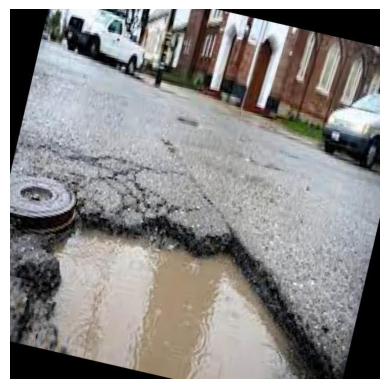

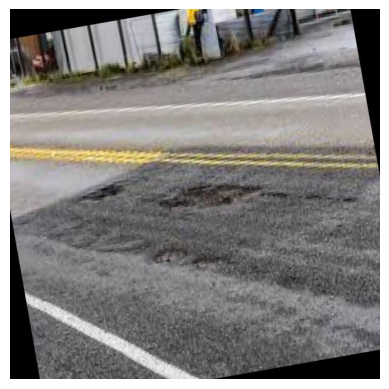

Epoch 21, Iteration 0: Loss = 0.13901576399803162
Epoch 21, Iteration 10: Loss = 0.1740521341562271
Epoch 21, Iteration 20: Loss = 0.05888887867331505
Epoch 21, Iteration 30: Loss = 0.13795001804828644
Epoch 21 completed. Average Loss: 0.0869
Epoch 22, Iteration 0: Loss = 0.08602161705493927
Epoch 22, Iteration 10: Loss = 0.1063501387834549
Epoch 22, Iteration 20: Loss = 0.060592327266931534
Epoch 22, Iteration 30: Loss = 0.09739089012145996
Epoch 22 completed. Average Loss: 0.0806
Epoch 23, Iteration 0: Loss = 0.07070184499025345
Epoch 23, Iteration 10: Loss = 0.07075729221105576
Epoch 23, Iteration 20: Loss = 0.09286733716726303
Epoch 23, Iteration 30: Loss = 0.10984330624341965
Epoch 23 completed. Average Loss: 0.0735
Epoch 24, Iteration 0: Loss = 0.07624880969524384
Epoch 24, Iteration 10: Loss = 0.08757112920284271
Epoch 24, Iteration 20: Loss = 0.10320033878087997
Epoch 24, Iteration 30: Loss = 0.07902929186820984
Epoch 24 completed. Average Loss: 0.0783
Epoch 25, Iteration 0: Lo

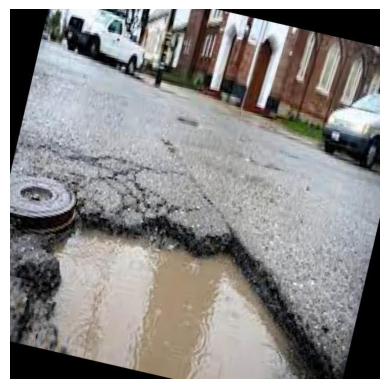

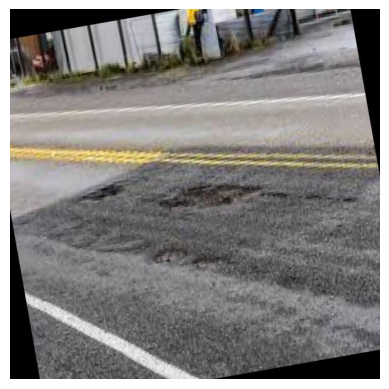

Epoch 31, Iteration 0: Loss = 0.04774702712893486
Epoch 31, Iteration 10: Loss = 0.03509606048464775
Epoch 31, Iteration 20: Loss = 0.09442213177680969
Epoch 31, Iteration 30: Loss = 0.07337909936904907
Epoch 31 completed. Average Loss: 0.0628
Epoch 32, Iteration 0: Loss = 0.05119295045733452
Epoch 32, Iteration 10: Loss = 0.03759876638650894
Epoch 32, Iteration 20: Loss = 0.1160375326871872
Epoch 32, Iteration 30: Loss = 0.06439550220966339
Epoch 32 completed. Average Loss: 0.0576
Epoch 33, Iteration 0: Loss = 0.043804604560136795
Epoch 33, Iteration 10: Loss = 0.07339075952768326
Epoch 33, Iteration 20: Loss = 0.04363206773996353
Epoch 33, Iteration 30: Loss = 0.0547025203704834
Epoch 33 completed. Average Loss: 0.0600
Epoch 34, Iteration 0: Loss = 0.054636962711811066
Epoch 34, Iteration 10: Loss = 0.05134611576795578
Epoch 34, Iteration 20: Loss = 0.107358917593956
Epoch 34, Iteration 30: Loss = 0.03635220602154732
Epoch 34 completed. Average Loss: 0.0560
Epoch 35, Iteration 0: Los

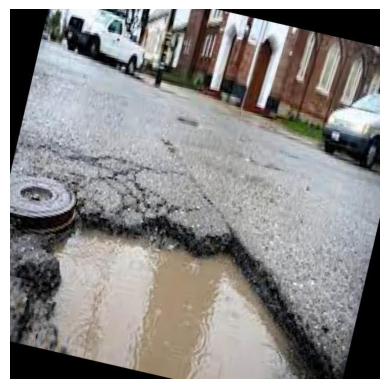

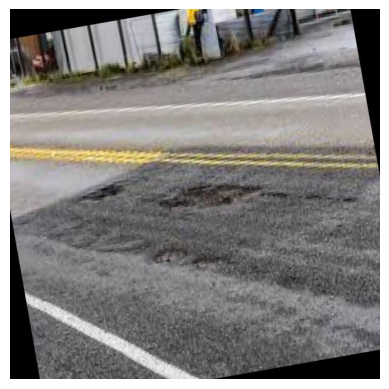

Epoch 41, Iteration 0: Loss = 0.037486910820007324
Epoch 41, Iteration 10: Loss = 0.0492047555744648
Epoch 41, Iteration 20: Loss = 0.06806068122386932
Epoch 41, Iteration 30: Loss = 0.08787457644939423
Epoch 41 completed. Average Loss: 0.0501
Epoch 42, Iteration 0: Loss = 0.05027922987937927
Epoch 42, Iteration 10: Loss = 0.03868774324655533
Epoch 42, Iteration 20: Loss = 0.026215124875307083
Epoch 42, Iteration 30: Loss = 0.03662830963730812
Epoch 42 completed. Average Loss: 0.0487
Epoch 43, Iteration 0: Loss = 0.04234950989484787
Epoch 43, Iteration 10: Loss = 0.03686873987317085
Epoch 43, Iteration 20: Loss = 0.04041789472103119
Epoch 43, Iteration 30: Loss = 0.020152390003204346
Epoch 43 completed. Average Loss: 0.0482
Epoch 44, Iteration 0: Loss = 0.04286609962582588
Epoch 44, Iteration 10: Loss = 0.04442785307765007
Epoch 44, Iteration 20: Loss = 0.09037033468484879
Epoch 44, Iteration 30: Loss = 0.08308808505535126
Epoch 44 completed. Average Loss: 0.0452
Epoch 45, Iteration 0:

In [ ]:
# Training loop with debugging statements
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    total_loss = 0  # Track total loss for the epoch
    for i, (images, targets) in enumerate(train_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass and optimizer step
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()

        if i % 10 == 0:
            print(f"Epoch {epoch}, Iteration {i}: Loss = {losses.item()}")

    average_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch} completed. Average Loss: {average_loss:.4f}")

    # Visualize predictions after a few epochs
    if epoch % 10 == 0:  # Change the condition as necessary
        model.eval()  # Set the model to eval mode
        with torch.no_grad():
            for images, targets in test_loader:
                images = list(image.to(device) for image in images)
                outputs = model(images)
                visualize_predictions(images, outputs)  # Call the visualization function
                break  # Show results for the first batch only


In [ ]:
def evaluate_and_calculate_metrics(model, loader, iou_threshold=0.5):
    model.eval()
    true_labels_flat = []
    pred_labels_flat = []

    with torch.no_grad():
        for images, targets in loader:
            images = list(image.to(device) for image in images)
            outputs = model(images)

            for target, output in zip(targets, outputs):
                # Get true boxes and labels
                true_boxes = target['boxes'].cpu().numpy()
                true_labels = target['labels'].cpu().numpy()

                print(f"True boxes: {true_boxes}, True labels: {true_labels}")

                # Perform NMS to filter predictions
                if len(output['boxes']) > 0:
                    keep = nms(output['boxes'], output['scores'], iou_threshold)
                    pred_boxes = output['boxes'][keep].cpu().numpy()
                    pred_labels = output['labels'][keep].cpu().numpy()
                    print(f"Predicted boxes: {pred_boxes}, Predicted labels: {pred_labels}")
                else:
                    pred_boxes = np.empty((0, 4))
                    pred_labels = np.empty((0,))
                    print("No predicted boxes.")

                # Add true labels to the flattened list
                true_labels_flat.extend(true_labels)

                # Initialize matched array
                matched = np.zeros(len(true_labels), dtype=bool)

                # Count matches
                for pred_box, pred_label in zip(pred_boxes, pred_labels):
                    # Calculate IoU with all true boxes
                    ious = compute_iou(pred_box, true_boxes)
                    max_iou_idx = np.argmax(ious)

                    # Check if IoU is above threshold
                    if ious[max_iou_idx] > iou_threshold and not matched[max_iou_idx]:
                        matched[max_iou_idx] = True
                        pred_labels_flat.append(pred_label)
                    else:
                        pred_labels_flat.append(0)  # No match found, mark as background (0)

                # Add unmatched true labels as false negatives
                true_labels_flat.extend(true_labels[~matched])

    # Convert to numpy arrays for sklearn metrics
    true_labels_flat = np.array(true_labels_flat)
    pred_labels_flat = np.array(pred_labels_flat)

    print(f"True labels (flattened): {true_labels_flat}")
    print(f"Predicted labels (flattened): {pred_labels_flat}")

    # Calculate metrics
    precision = precision_score(true_labels_flat, pred_labels_flat, average='weighted', zero_division=0)
    recall = recall_score(true_labels_flat, pred_labels_flat, average='weighted', zero_division=0)
    f1 = f1_score(true_labels_flat, pred_labels_flat, average='weighted', zero_division=0)

    return precision, recall, f1

# Call the evaluation function after training
precision, recall, f1 = evaluate_and_calculate_metrics(model, test_loader)
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")


True boxes: [[  0. 330. 531. 640.]], True labels: [2]
Predicted boxes: [[ 19.512232 229.4646   422.36203  352.51447 ]], Predicted labels: [1]
True boxes: [[120. 300. 187. 328.]
 [267. 280. 472. 355.]], True labels: [2 2]
No predicted boxes.
True boxes: [[190. 523. 302. 554.]
 [289. 563. 407. 608.]], True labels: [2 2]
No predicted boxes.
True boxes: [[  8.  35. 600. 404.]], True labels: [2]
No predicted boxes.
True boxes: [[ 21. 506. 231. 640.]
 [402. 316. 449. 341.]
 [ 14. 380. 158. 488.]], True labels: [2 2 2]
Predicted boxes: [[381.22736 296.24664 595.2109  340.91876]], Predicted labels: [1]
True boxes: [[106. 239. 439. 429.]], True labels: [2]
No predicted boxes.
True boxes: [[  1. 431.  56. 468.]
 [457. 492. 640. 640.]
 [209. 321. 247. 350.]], True labels: [2 2 2]
No predicted boxes.
True boxes: [[  0. 448. 597. 640.]], True labels: [2]
Predicted boxes: [[ 18.572926 286.02563  248.78996  334.36813 ]], Predicted labels: [1]
True boxes: [[302. 331. 335. 363.]
 [310. 276. 342. 317.]


ValueError: Found input variables with inconsistent numbers of samples: [642, 157]